In [1]:
import fitsio
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial
from scipy import stats

In [2]:
import lib

In [3]:
lib.plotting.setup()

In [4]:
shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

In [5]:
NBINS = 100
bins = np.linspace(0, 3, NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

In [6]:
fits = fitsio.FITS("/global/cfs/cdirs/des/y6-shear-catalogs/y6a2_piff_v3_HOMSs_v1_unique.fits")

In [7]:
d = fits[1].read()

In [8]:
TvsGI_bins = np.linspace(0, 3.5, 101)
TvsGI_centers = 0.5 * (TvsGI_bins[:-1] + TvsGI_bins[1:])
TvsGI, _, _ = stats.binned_statistic(
    d["GI_COLOR"],
    d["T_MODEL"],
    statistic="median",
    bins=TvsGI_bins,
)

In [9]:
p = np.polynomial.Polynomial.fit(TvsGI_centers, TvsGI, deg=1)
# p = np.polynomial.Polynomial.fit(
#     d["GI_COLOR"],
#     d["T_MODEL"],
#     deg=1,
# )

In [10]:
p_deriv = p.deriv(1)

In [11]:
T_GI_COLOR = p(lib.const.GI_COLOR)

In [12]:
NBINS = 100
bins = np.linspace(0, 3, NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus]) as shear_plus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_plus]) as truth_plus,
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus]) as shear_minus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_minus]) as truth_minus,
):
    flux_g_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    flux_err_g_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_err_g"][:]
    flux_err_i_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_err_i"][:]

    # color_plus = lib.util.flux_to_mag(flux_g_plus) - lib.util.flux_to_mag(flux_i_plus)
    mag_g_plus, mag_err_g_plus = lib.util.flux_to_mag_with_error(flux_g_plus, flux_err_g_plus)
    mag_i_plus, mag_err_i_plus = lib.util.flux_to_mag_with_error(flux_i_plus, flux_err_i_plus)
    color_plus = mag_g_plus - mag_i_plus
    color_err_plus = np.sqrt(np.square(mag_err_g_plus) + np.square(mag_err_i_plus))

    redshift_plus = truth_plus["mdet"]["noshear"]["z"][:]
    gal_T_plus = shear_plus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_plus["mdet"]["noshear"]["gauss_psf_T"][:]
    gal_T_err_plus = shear_plus["mdet"]["noshear"]["gauss_T_err"][:]
    psf_T_plus = p(color_plus)
    psf_T_err_plus = p_deriv(color_plus) * color_err_plus

    m_plus = -(psf_T_plus - T_GI_COLOR) / gal_T_plus
    # m_err_plus = psf_T_err_plus / gal_T_plus
    m_err_plus = np.sqrt(np.square(psf_T_err_plus / gal_T_plus) + np.square((psf_T_plus - T_GI_COLOR) / np.square(gal_T_plus) * gal_T_err_plus))

    flux_g_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    flux_err_g_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_err_g"][:]
    flux_err_i_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_err_i"][:]

    # color_minus = lib.util.flux_to_mag(flux_g_minus) - lib.util.flux_to_mag(flux_i_minus)
    mag_g_minus, mag_err_g_minus = lib.util.flux_to_mag_with_error(flux_g_minus, flux_err_g_minus)
    mag_i_minus, mag_err_i_minus = lib.util.flux_to_mag_with_error(flux_i_minus, flux_err_i_minus)
    color_minus = mag_g_minus - mag_i_minus
    color_err_minus = np.sqrt(np.square(mag_err_g_minus) + np.square(mag_err_i_minus))
        
    redshift_minus = truth_minus["mdet"]["noshear"]["z"][:]
    gal_T_minus = shear_minus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_minus["mdet"]["noshear"]["gauss_psf_T"][:]
    gal_T_err_minus = shear_minus["mdet"]["noshear"]["gauss_T_err"][:]
    psf_T_minus = p(color_minus)
    psf_T_err_minus = p_deriv(color_minus) * color_err_minus

    m_minus = -(psf_T_minus - T_GI_COLOR) / gal_T_minus
    # m_err_minus = psf_T_err_minus / gal_T_minus
    m_err_minus = np.sqrt(np.square(psf_T_err_minus / gal_T_minus) + np.square((psf_T_minus - T_GI_COLOR) / np.square(gal_T_minus) * gal_T_err_minus))

    count_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        None,
        statistic="count",
        bins=bins,
    )
    mean_color_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        color_plus,
        statistic="mean",
        bins=bins,
    )
    std_color_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        color_plus,
        statistic="std",
        bins=bins,
    )
    mean_size_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        psf_T_plus,
        statistic="mean",
        bins=bins,
    )
    std_size_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        psf_T_plus,
        statistic="std",
        bins=bins,
    )
    mean_m_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        m_plus,
        statistic="mean",
        bins=bins,
    )
    std_m_plus, _, _ = stats.binned_statistic(
        redshift_plus,
        m_plus,
        statistic="std",
        bins=bins,
    )

    count_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        None,
        statistic="count",
        bins=bins,
    )        
    mean_color_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        color_minus,
        statistic="mean",
        bins=bins,
    )
    std_color_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        color_minus,
        statistic="std",
        bins=bins,
    )
    mean_size_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        psf_T_minus,
        statistic="mean",
        bins=bins,
    )
    std_size_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        psf_T_minus,
        statistic="std",
        bins=bins,
    )
    mean_m_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        m_minus,
        statistic="mean",
        bins=bins,
    )
    std_m_minus, _, _ = stats.binned_statistic(
        redshift_minus,
        m_minus,
        statistic="std",
        bins=bins,
    )

count_sim = 0.5 * (count_plus + count_minus)

mean_color_sim = 0.5 * (mean_color_plus + mean_color_minus)
std_color_sim = 0.5 * (std_color_plus / np.sqrt(count_plus) + std_color_minus / np.sqrt(count_minus))
# std_color_sim = 0.5 * (std_color_plus + std_color_minus)

mean_size_sim = 0.5 * (mean_size_plus + mean_size_minus)
std_size_sim = 0.5 * (std_size_plus / np.sqrt(count_plus) + std_size_minus / np.sqrt(count_minus))
# std_size_sim = 0.5 * (std_size_plus + std_size_minus)

mean_m_sim = 0.5 * (mean_m_plus + mean_m_minus)
std_m_sim = 0.5 * (std_m_plus / np.sqrt(count_plus) + std_m_minus / np.sqrt(count_minus))
# std_m_sim = 0.5 * (std_m_plus + std_m_minus)

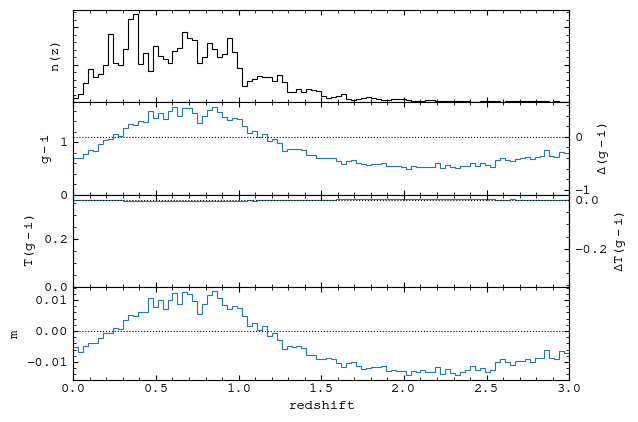

In [13]:
fig, axs = plt.subplots(4, 1, sharex=True)

fig.subplots_adjust(hspace=0)

axs[0].stairs(count_sim, bins, ec="k")

axs[1].axhline(lib.const.GI_COLOR, ls=":")
# axs[1].errorbar(centers, mean_color_sim, std_color_sim, fmt="o", c="k")
# axs[1].plot(centers, mean_color_sim)
axs[1].stairs(mean_color_sim, bins)

_axs1 = axs[1].secondary_yaxis(
    "right",
    functions=(
        lambda x: x - lib.const.GI_COLOR,
        lambda x: x + lib.const.GI_COLOR,
    ),
)

axs[2].axhline(p(lib.const.GI_COLOR), ls=":")
# axs[2].errorbar(centers, mean_size_sim, std_size_sim, fmt="o", c="k")
# axs[2].plot(centers, mean_size_sim)
axs[2].stairs(mean_size_sim, bins)

_axs2 = axs[2].secondary_yaxis(
    "right",
    functions=(
        lambda x: x - T_GI_COLOR,
        lambda x: x + T_GI_COLOR,
    ),
)

axs[3].axhline(0, ls=":")
# axs[3].errorbar(centers, mean_m_sim, std_m_sim, fmt="o", c="k")
# axs[3].plot(centers, mean_m_sim)
axs[3].stairs(mean_m_sim, bins)


# axs[4].stairs(count_sim * (1 + mean_m_sim - error_m_sim), bins, ec="k", ls=":")
# axs[4].stairs(count_sim * (1 + mean_m_sim + error_m_sim), bins, ec="k", ls=":")
# axs[4].stairs(count_sim * (1 + mean_m_sim), bins, ec="k")

axs[-1].set_xlabel("redshift")
axs[-1].set_xlim(0, 3)
axs[0].set_yticklabels([])
axs[0].set_ylabel("$n(z)$")
axs[1].set_ylabel(f"$g - i$")
axs[1].tick_params(axis="y", which="both", right=False)
_axs1.set_ylabel("$\\Delta (g - i)$")
axs[2].set_ylabel("$T(g - i)$")
axs[2].tick_params(axis="y", which="both", right=False)
_axs2.set_ylabel("$\\Delta T(g - i)$")
axs[3].set_ylabel("$m$")

plt.show()

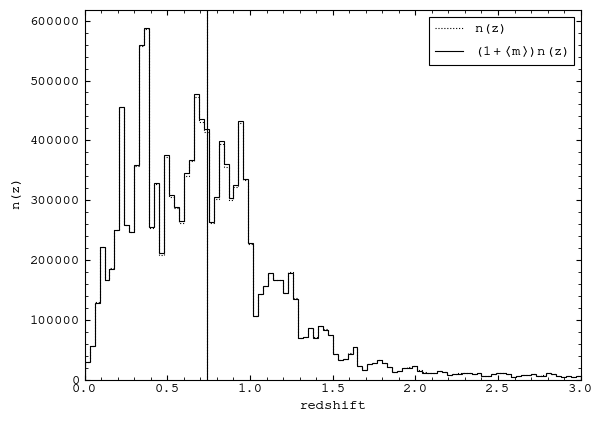

In [14]:
fig, axs = plt.subplots(1, 1)

axs.axvline(np.average(centers, weights=count_sim), ls=":")
axs.stairs(count_sim, bins, ec="k", ls=":", label="$n(z)$")

axs.axvline(np.average(centers, weights=(1 + mean_m_sim) * count_sim))
axs.stairs((1 + mean_m_sim) * count_sim, bins, ec="k", label="$(1 + 〈m〉) n(z)$")

axs.set_xlabel("redshift")
axs.set_xlim(0, 3)
axs.set_ylabel("$n(z)$")
axs.legend(loc="upper right")

plt.show()

In [18]:
NBINS = 100
bins = np.linspace(0, 3, NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])

count_sim = {}
mean_color_sim = {}
error_color_sim = {}
# std_color_sim = {}
mean_size_sim = {}
error_size_sim = {}
# std_size_sim = {}
mean_m_sim = {}
error_m_sim = {}
# std_m_sim = {}
tomo_mean_m_sim = {}
tomo_error_m_sim = {}
# tomo_std_m_sim = {}
tomo_mean_dz_sim = {}
tomo_error_dz_sim = {}
# tomo_std_dz_sim = {}

with (
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_plus]) as shear_plus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_plus]) as truth_plus,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step_plus]) as tomo_plus,
    h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step_minus]) as shear_minus,
    h5py.File(lib.const.SIM_MATCH_CATALOGS[shear_step_minus]) as truth_minus,
    h5py.File(lib.const.SIM_TOMOGRAPHY_CATALOGS[shear_step_minus]) as tomo_minus,

):

    flux_g_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    # flux_err_g_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_err_g"][:]
    # flux_err_i_plus = shear_plus["mdet"]["noshear"]["pgauss_band_flux_err_i"][:]

    # color_plus = lib.util.flux_to_mag(flux_g_plus) - lib.util.flux_to_mag(flux_i_plus)
    mag_g_plus, mag_err_g_plus = lib.util.flux_to_mag_with_error(flux_g_plus, flux_err_g_plus)
    mag_i_plus, mag_err_i_plus = lib.util.flux_to_mag_with_error(flux_i_plus, flux_err_i_plus)
    color_plus = mag_g_plus - mag_i_plus
    # color_err_plus = np.sqrt(np.square(mag_err_g_plus) + np.square(mag_err_i_plus))

    redshift_plus = truth_plus["mdet"]["noshear"]["z"][:]
    gal_T_plus = shear_plus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_plus["mdet"]["noshear"]["gauss_psf_T"][:]
    # gal_T_err_plus = shear_plus["mdet"]["noshear"]["gauss_T_err"][:]
    psf_T_plus = p(color_plus)
    # psf_T_err_plus = p_deriv(color_plus) * color_err_plus

    m_plus = -(psf_T_plus - T_GI_COLOR) / gal_T_plus
    # m_err_plus = psf_T_err_plus / gal_T_plus
    # m_err_plus = np.sqrt(np.square(psf_T_err_plus / gal_T_plus) + np.square((psf_T_plus - T_GI_COLOR) / np.square(gal_T_plus) * gal_T_err_plus))

    bhat_plus = tomo_plus["sompz"]["noshear"]["bhat"][:]

    flux_g_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_g_nodered"][:]
    flux_i_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_i_nodered"][:]
    # flux_err_g_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_err_g"][:]
    # flux_err_i_minus = shear_minus["mdet"]["noshear"]["pgauss_band_flux_err_i"][:]

    # color_minus = lib.util.flux_to_mag(flux_g_minus) - lib.util.flux_to_mag(flux_i_minus)
    mag_g_minus, mag_err_g_minus = lib.util.flux_to_mag_with_error(flux_g_minus, flux_err_g_minus)
    mag_i_minus, mag_err_i_minus = lib.util.flux_to_mag_with_error(flux_i_minus, flux_err_i_minus)
    color_minus = mag_g_minus - mag_i_minus
    # color_err_minus = np.sqrt(np.square(mag_err_g_minus) + np.square(mag_err_i_minus))
        
    redshift_minus = truth_minus["mdet"]["noshear"]["z"][:]
    gal_T_minus = shear_minus["mdet"]["noshear"]["gauss_T_ratio"][:] * shear_minus["mdet"]["noshear"]["gauss_psf_T"][:]
    # gal_T_err_minus = shear_minus["mdet"]["noshear"]["gauss_T_err"][:]
    psf_T_minus = p(color_minus)
    # psf_T_err_minus = p_deriv(color_minus) * color_err_minus

    m_minus = -(psf_T_minus - T_GI_COLOR) / gal_T_minus
    # m_err_minus = psf_T_err_minus / gal_T_minus
    # m_err_minus = np.sqrt(np.square(psf_T_err_minus / gal_T_minus) + np.square((psf_T_minus - T_GI_COLOR) / np.square(gal_T_minus) * gal_T_err_minus))

    bhat_minus = tomo_minus["sompz"]["noshear"]["bhat"][:]

    # ---

    
    for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
        in_tomo_plus = (bhat_plus == tomographic_bin)
        in_tomo_minus = (bhat_minus == tomographic_bin)

        _count_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            None,
            statistic="count",
            bins=bins,
        )
        _mean_color_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            color_plus[in_tomo_plus],
            statistic="mean",
            bins=bins,
        )
        _std_color_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            color_plus[in_tomo_plus],
            statistic="std",
            bins=bins,
        )
        # _error_color_plus, _, _ = stats.binned_statistic(
        #     redshift_plus[in_tomo_plus],
        #     color_err_plus[in_tomo_plus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
        _mean_size_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            psf_T_plus[in_tomo_plus],
            statistic="mean",
            bins=bins,
        )
        _std_size_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            psf_T_plus[in_tomo_plus],
            statistic="std",
            bins=bins,
        )
        # _error_size_plus, _, _ = stats.binned_statistic(
        #     redshift_plus[in_tomo_plus],
        #     psf_T_err_plus[in_tomo_plus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
        _mean_m_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            m_plus[in_tomo_plus],
            statistic="mean",
            bins=bins,
        )
        _std_m_plus, _, _ = stats.binned_statistic(
            redshift_plus[in_tomo_plus],
            m_plus[in_tomo_plus],
            statistic="std",
            bins=bins,
        )
        # _error_m_plus, _, _ = stats.binned_statistic(
        #     redshift_plus[in_tomo_plus],
        #     m_err_plus[in_tomo_plus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
    
        _count_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            None,
            statistic="count",
            bins=bins,
        )        
        _mean_color_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            color_minus[in_tomo_minus],
            statistic="mean",
            bins=bins,
        )
        _std_color_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            color_minus[in_tomo_minus],
            statistic="std",
            bins=bins,
        )
        # _error_color_minus, _, _ = stats.binned_statistic(
        #     redshift_minus[in_tomo_minus],
        #     color_err_minus[in_tomo_minus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
        _mean_size_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            psf_T_minus[in_tomo_minus],
            statistic="mean",
            bins=bins,
        )
        _std_size_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            psf_T_minus[in_tomo_minus],
            statistic="std",
            bins=bins,
        )
        # _error_size_minus, _, _ = stats.binned_statistic(
        #     redshift_minus[in_tomo_minus],
        #     psf_T_err_minus[in_tomo_minus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
        _mean_m_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            m_minus[in_tomo_minus],
            statistic="mean",
            bins=bins,
        )
        _std_m_minus, _, _ = stats.binned_statistic(
            redshift_minus[in_tomo_minus],
            m_minus[in_tomo_minus],
            statistic="std",
            bins=bins,
        )
        # _error_m_minus, _, _ = stats.binned_statistic(
        #     redshift_minus[in_tomo_minus],
        #     m_err_minus[in_tomo_minus],
        #     statistic=sum_of_squares,
        #     bins=bins,
        # )
  
        count_sim[tomographic_bin] = 0.5 * (_count_plus + _count_minus)

        mean_color_sim[tomographic_bin] = 0.5 * (_mean_color_plus + _mean_color_minus)
        error_color_sim[tomographic_bin] = 0.5 * (_std_color_plus / np.sqrt(_count_plus) + _std_color_minus / np.sqrt(_count_minus))
        # error_color_sim[tomographic_bin] = 0.5 * (np.sqrt(_error_color_plus / _count_plus) + np.sqrt(_error_color_minus / _count_minus))

        mean_size_sim[tomographic_bin] = 0.5 * (_mean_size_plus + _mean_size_minus)
        error_size_sim[tomographic_bin] = 0.5 * (_std_size_plus / np.sqrt(_count_plus) + _std_size_minus / np.sqrt(_count_minus))
        # error_size_sim[tomographic_bin] = 0.5 * (np.sqrt(_error_size_plus / _count_plus) + np.sqrt(_error_size_minus / _count_minus))

        mean_m_sim[tomographic_bin] = 0.5 * (_mean_m_plus + _mean_m_minus)
        error_m_sim[tomographic_bin] = 0.5 * (_std_m_plus / np.sqrt(_count_plus) + _std_m_minus / np.sqrt(_count_minus))
        # error_m_sim[tomographic_bin] = 0.5 * (np.sqrt(_error_m_plus / _count_plus) + np.sqrt(_error_m_minus / _count_minus))

        _tomo_mean_m_plus = np.mean(_mean_m_plus)
        _tomo_error_m_plus = np.sqrt(np.sum(np.square(_std_m_plus)) / np.sum(in_tomo_plus))
    
        _tomo_mean_m_minus = np.mean(_mean_m_minus)
        _tomo_error_m_minus = np.sqrt(np.sum(np.square(_std_m_minus)) / np.sum(in_tomo_minus))

        _tomo_mean_dz_plus = np.average(
            redshift_plus[in_tomo_plus],
            weights=(1 + m_plus[in_tomo_plus]),
        ) - np.average(redshift_plus[in_tomo_plus])
        _tomo_error_dz_plus = np.std(m_plus[in_tomo_plus]) / np.sum(in_tomo_plus)
        
        _tomo_mean_dz_minus = np.average(
            redshift_minus[in_tomo_minus],
            weights=(1 + m_minus[in_tomo_minus]),
        ) - np.average(redshift_minus[in_tomo_minus])
        _tomo_error_dz_minus = np.std(m_minus[in_tomo_minus]) / np.sum(in_tomo_minus)
        
        tomo_mean_m_sim[tomographic_bin] = 0.5 * (_tomo_mean_m_plus + _tomo_mean_m_minus)
        tomo_error_m_sim[tomographic_bin] = 0.5 * (_tomo_error_m_plus + _tomo_error_m_minus)

        tomo_mean_dz_sim[tomographic_bin] = 0.5 * (_tomo_mean_dz_plus + _tomo_mean_dz_minus)
        tomo_error_dz_sim[tomographic_bin] = 0.5 * (_tomo_error_dz_plus + _tomo_error_dz_minus)


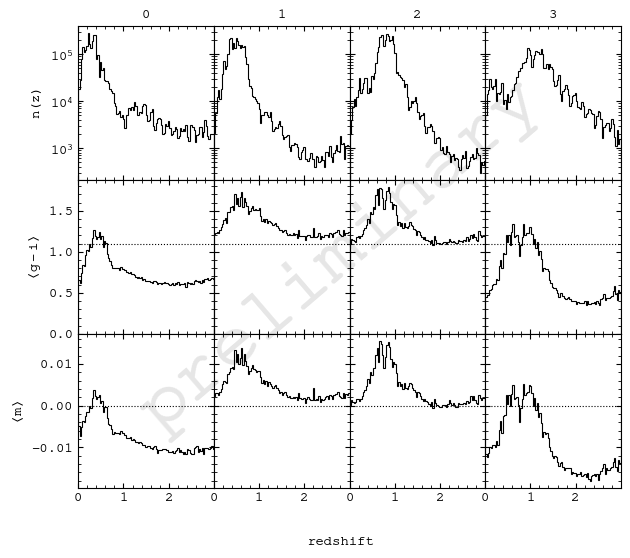

In [19]:
fig, axs = plt.subplots(3, 4, figsize=(7, 6), sharex=True, sharey="row")

fig.subplots_adjust(hspace=0, wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    axs[0, tomographic_bin].stairs(count_sim[tomographic_bin], bins, ec="k")
    
    axs[1, tomographic_bin].axhline(lib.const.GI_COLOR, ls=":")
    # axs[1, tomographic_bin].errorbar(centers, mean_color_sim[tomographic_bin], error_color_sim[tomographic_bin], fmt="o", c="k")
    axs[1, tomographic_bin].stairs(mean_color_sim[tomographic_bin], bins, ec="k")

    # axs[2, tomographic_bin].axhline(T_GI_COLOR, ls=":")
    # # axs[2, tomographic_bin].errorbar(centers, mean_size_sim[tomographic_bin], error_size_sim[tomographic_bin], fmt="o", c="k")
    # axs[2, tomographic_bin].stairs(mean_size_sim[tomographic_bin], bins, ec="k")

    axs[2, tomographic_bin].axhline(0, ls=":")
    # axs[3, tomographic_bin].errorbar(centers, mean_m_sim[tomographic_bin], error_m_sim[tomographic_bin], fmt="o", c="k")
    axs[2, tomographic_bin].stairs(mean_m_sim[tomographic_bin], bins, ec="k")

    axs[0, tomographic_bin].set_title(tomographic_bin)

fig.supxlabel("redshift")
axs[-1, -1].set_xlim(0, 3)
axs[-1, -1].set_xticks([0, 1, 2])
# axs[0, 0].set_yticklabels([])
axs[0, 0].set_yscale("log")
axs[0, 0].set_ylabel("$n(z)$")
axs[1, 0].set_ylabel(f"$〈 g - i 〉$")
# axs[2, 0].set_ylabel("$〈 T(g - i) 〉$")
axs[2, 0].set_ylabel("$〈m〉$")

lib.plotting.watermark(fig)

fig.savefig("chromatic_bias.pdf")
plt.show()
    

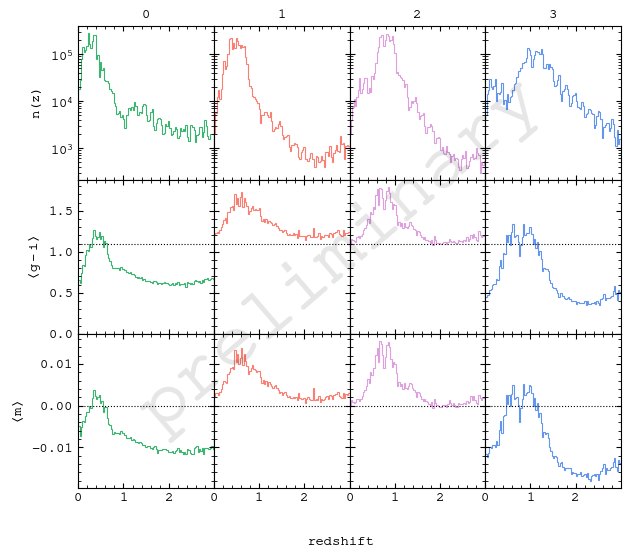

In [28]:
tomo_colors = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

fig, axs = plt.subplots(3, 4, figsize=(7, 6), sharex=True, sharey="row")

fig.subplots_adjust(hspace=0, wspace=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:

    axs[0, tomographic_bin].stairs(
        count_sim[tomographic_bin],
        bins,
        ec=tomo_colors[tomographic_bin],
    )
    
    axs[1, tomographic_bin].axhline(lib.const.GI_COLOR, ls=":")
    axs[1, tomographic_bin].stairs(
        mean_color_sim[tomographic_bin],
        bins,
        ec=tomo_colors[tomographic_bin],
    )

    axs[2, tomographic_bin].axhline(0, ls=":")
    axs[2, tomographic_bin].stairs(
        mean_m_sim[tomographic_bin],
        bins,
        ec=tomo_colors[tomographic_bin],
    )

    axs[0, tomographic_bin].set_title(tomographic_bin)

fig.supxlabel("redshift")
axs[-1, -1].set_xlim(0, 3)
axs[-1, -1].set_xticks([0, 1, 2])
# axs[0, 0].set_yticklabels([])
axs[0, 0].set_yscale("log")
axs[0, 0].set_ylabel("$n(z)$")
axs[1, 0].set_ylabel(f"$〈 g - i 〉$")
# axs[2, 0].set_ylabel("$〈 T(g - i) 〉$")
axs[2, 0].set_ylabel("$〈m〉$")

lib.plotting.watermark(fig)

fig.savefig("chromatic_bias.pdf")
plt.show()
    

In [27]:
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{tomographic_bin}:"
        "\t"
        f"m = {tomo_mean_m_sim[tomographic_bin]:+7.4f} ± {tomo_error_m_sim[tomographic_bin]:6.8f}"
        "\t"
        f"dz = {tomo_mean_dz_sim[tomographic_bin]:+7.4f} ± {tomo_error_dz_sim[tomographic_bin]:6.8f}"
    )

0:	m = -0.0076 ± 0.00004348	dz = -0.0011 ± 0.00000000
1:	m = +0.0046 ± 0.00005083	dz = -0.0001 ± 0.00000000
2:	m = +0.0037 ± 0.00005336	dz = -0.0002 ± 0.00000000
3:	m = -0.0092 ± 0.00006911	dz = -0.0018 ± 0.00000001


In [26]:
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    print(
        f"{tomographic_bin}",
        "&",
        f"${tomo_mean_m_sim[tomographic_bin] / 1e-3:+7.4f}$",
        "&",
        f"${tomo_mean_dz_sim[tomographic_bin]:+7.4f}$",
        "\\\\",
    )

0 & $-7.5872$ & $-0.0011$ \\
1 & $+4.5662$ & $-0.0001$ \\
2 & $+3.7231$ & $-0.0002$ \\
3 & $-9.2181$ & $-0.0018$ \\
